In [55]:
using VegaLite
using PlotlyJS
include("./utils.jl")
include("./unit_commitment.jl")
ENV["COLUMNS"]=120 # Set so all columns of DataFrames and Matrices are displayed

120

In [56]:

gen_info, fuels, loads, gen_variable_info, storage_info = read_data()
gen_df = pre_process_generators_data(gen_info, fuels)
storage_df = pre_process_storage_data(storage_info)

# A spring day
n=100
T_period = (n*24+1):((n+1)*24)

# High solar case: 3,500 MW
gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500
gen_variable = pre_process_gen_variable(gen_df_sens, gen_variable_info)

# Filtering data with timeseries according to T_period
gen_variable_multi = gen_variable[in.(gen_variable.hour,Ref(T_period)),:];
loads_multi = loads[in.(loads.hour,Ref(T_period)),:];

reserve = DataFrame(
    hour = loads[in.(loads.hour, Ref(T_period)), :hour],
    up = 300 .+ loads[in.(loads.hour,Ref(T_period)), :demand].*0.05,
    down = loads[in.(loads.hour, Ref(T_period)), :demand].*0.05)


energy_reserve = [(row_1.hour, row_2.hour, row_1.up*(row_1.hour == row_2.hour), row_1.down*(row_1.hour == row_2.hour)) for row_1 in eachrow(reserve), row_2 in eachrow(reserve) if row_1.hour <= row_2.hour]
energy_reserve = DataFrame(energy_reserve)
energy_reserve = rename(energy_reserve, :1 => :i_hour, :2 => :t_hour, :3 => :up, :4 => :down,)
;

### Simple Unit Commitment

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.01
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 2762 rows, 2232 columns and 9228 nonzeros
Model fingerprint: 0x92c3bc8b
Variable types: 648 continuous, 1584 integer (1584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [5e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 164 rows and 116 columns
Presolve time: 0.04s
Presolved: 2598 rows,

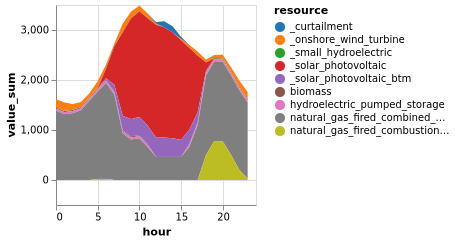

In [57]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.01,
    ramp_constraints = false)
    sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :value => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    value_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :value => sum)
curtail[!, :resource] .= "_curtailment"
# rename!(curtail, :curt_sum => :value_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :value_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

### Unit Commitment with ramp

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.01
Adding ramp constraints...


Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 4532 rows, 2760 columns and 13296 nonzeros
Model fingerprint: 0x00f527e7
Variable types: 1176 continuous, 1584 integer (1584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [5e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 1846 rows and 644 columns
Presolve time: 0.02s
Presolved: 2686 rows, 2116 columns, 10736 nonzeros
Variable types: 576 continuous, 1540 integer (1540 binary)
Found heuristic solution: objective 898512.70762

Root relaxation: objective 8.539093e+05, 959 iterations, 0.01 seconds (0.02 

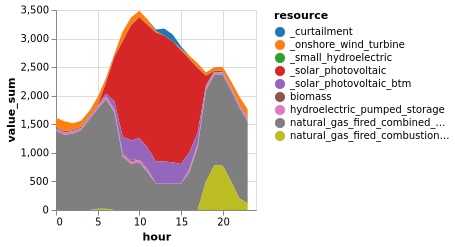

In [58]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.01,
    ramp_constraints = true)
    sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :value => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    value_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :value => sum)
curtail[!, :resource] .= "_curtailment"
# rename!(curtail, :curt_sum => :value_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :value_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

### Unit commitment ramp and reserve

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding ramp constraints...
Adding reserve constraints...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 6692 rows, 3816 columns and 18576 nonzeros
Model fingerprint: 0x89b245e1
Variable types: 2232 continuous, 1584 integer (1584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [5e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 2950 rows and 692 columns
Presolve time: 0.03s
Presolved: 3742 rows, 3124 columns, 14768 nonzeros
Variable types: 1584 continuous, 1540 integer (1540 binary)

Root relaxation: objective 8.971854e+05, 3137 iterations, 0.04 seconds (0.04 work units)

    Nodes    |    Current Node   

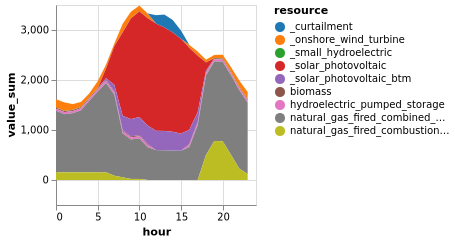

In [59]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    reserve = reserve)
sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :value => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    value_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :value => sum)
curtail[!, :resource] .= "_curtailment"
# rename!(curtail, :curt_sum => :value_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :value_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

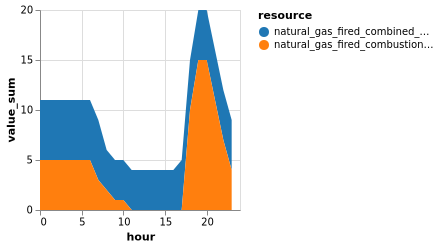

In [60]:
sol_commit = innerjoin(solution.commit, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_commit = combine(groupby(sol_commit, [:resource, :hour]), 
            :value => sum)
sol_commit.hour = sol_commit.hour .- T_period[1]

sol_commit |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

### Unit commitment ramp and energy reserve

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding ramp constraints...
Adding energy reserve constraints...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 31532 rows, 15960 columns and 281696 nonzeros
Model fingerprint: 0x0230378f
Variable types: 14376 continuous, 1584 integer (1584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [5e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 20242 rows and 5840 columns
Presolve time: 0.76s
Presolved: 11290 rows, 10120 columns, 255445 nonzeros
Variable types: 8580 continuous, 1540 integer (1540 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.

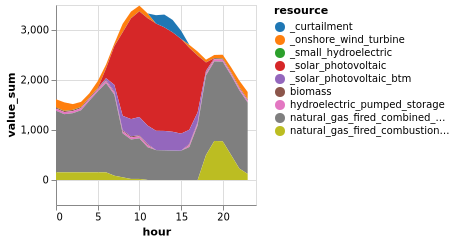

In [61]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    energy_reserve = energy_reserve)
    sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :value => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    value_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :value => sum)
curtail[!, :resource] .= "_curtailment"
# rename!(curtail, :curt_sum => :value_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :value_sum]])

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

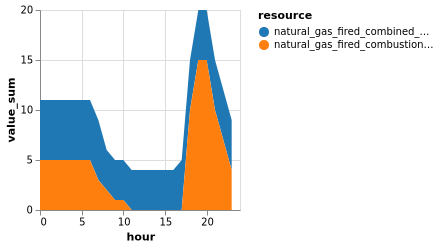

In [62]:
sol_commit = innerjoin(solution.commit, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_commit = combine(groupby(sol_commit, [:resource, :hour]), 
            :value => sum)
sol_commit.hour = sol_commit.hour .- T_period[1]

sol_commit |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

### Unit commitment ramp and electrical storage

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding ramp constraints...
Adding storage...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 6692 rows, 3720 columns and 17076 nonzeros
Model fingerprint: 0x6ec01c60
Variable types: 1896 continuous, 1824 integer (1824 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e-01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 3316 rows and 674 columns
Presolve time: 0.03s
Presolved: 3376 rows, 3046 columns, 13026 nonzeros
Variable types: 1266 continuous, 1780 integer (1780 binary)

Root relaxation: objective 6.032806e+05, 566 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    

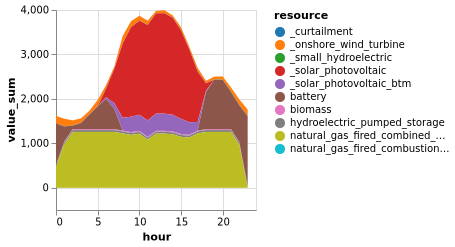

In [63]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    storage = storage_df
    );

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :value => sum)

# Rename generators (for plotting purposes)
sol_gen[sol_gen.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen[sol_gen.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen[sol_gen.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

# BTM solar
btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    value_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen, btm)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :value => sum)
curtail[!, :resource] .= "_curtailment"
# rename!(curtail, :curt_sum => :value_sum)
append!(sol_gen, curtail[:,[:resource, :hour, :value_sum]])

# Storage
if haskey(solution, :dis)
    storage_ch = innerjoin(
        solution.dis, 
        storage_df[!, [:r_id, :resource]], 
        on = :r_id)
    storage_ch = combine(groupby(storage_ch, [:resource, :hour]), :value => sum)
    append!(sol_gen, storage_ch)
end
# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]

sol_gen |>
@vlplot(:area, 
    x=:hour, y={:value_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

In [64]:
solution = solve_unit_commitment(
    gen_df_sens,
    loads_multi,
    gen_variable_multi,
    0.001,
    ramp_constraints = true,
    storage = storage_df,
    enriched_solution = true);

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2475843
Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Set parameter MIPGap to value 0.001
Adding ramp constraints...
Adding storage...


Set parameter MIPGap to value 0.001
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2475843 - for non-commercial use only - registered to pa___@imperial.ac.uk
Optimize a model with 6692 rows, 3720 columns and 17076 nonzeros
Model fingerprint: 0x6ec01c60
Variable types: 1896 continuous, 1824 integer (1824 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e-01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 3316 rows and 674 columns
Presolve time: 0.03s
Presolved: 3376 rows, 3046 columns, 13026 nonzeros
Variable types: 1266 continuous, 1780 integer (1780 binary)

Root relaxation: objective 6.032806e+05, 566 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    

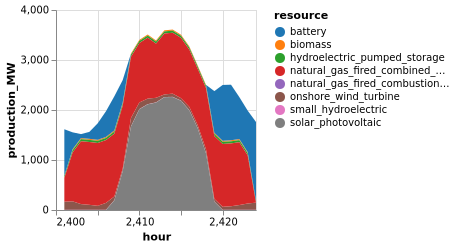

In [65]:
supply = combine(groupby(solution.generation, [:hour, :resource]), :production_MW => sum, renamecols=false)
supply_ch = combine(groupby(solution.storage, [:hour, :resource]), :discharge_MW => sum, renamecols=false)
rename!(supply_ch, :discharge_MW => :production_MW)
append!(supply, supply_ch)
supply |>
@vlplot(:area, 
    x=:hour, y={:production_MW, stack=:zero}, 
    color={"resource:n", scale={scheme="category10"}})

In [66]:
# sol_commit = innerjoin(solution.commit, 
#                     gen_df[!, [:r_id, :resource]], 
#                     on = :r_id)
# sol_commit = combine(groupby(sol_commit, [:resource, :hour]), 
#             :value => sum)
# sol_commit.hour = sol_commit.hour .- T_period[1]

# sol_commit |>
# @vlplot(:area, 
#     x=:hour, y={:value_sum, stack=:zero}, 
#     color={"resource:n", scale={scheme="category10"}})

In [67]:
# to_plot = copy(solution.SOE)
# to_plot.hour = to_plot.hour .- T_period[1]
# plot(to_plot, x = :hour, y = :value, group = :r_id)

In [68]:
# to_plot = copy(solution.dis)
# to_plot.hour = to_plot.hour .- T_period[1]
# plot(to_plot, x = :hour, y = :value, group = :r_id)

In [69]:
# to_plot = copy(solution.ch)
# to_plot.hour = to_plot.hour .- T_period[1]
# plot(to_plot, x = :hour, y = :value, group = :r_id)